<a href="https://colab.research.google.com/github/AloniRegev/Defense-Against-Adversarial-Examples-in-NN/blob/Neta-dev/DL_project_adversary_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#imports
from torch._C import NoneType
import torch
import torchvision
import torchvision.datasets as datasets
from torch import optim
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchsummary import summary

import copy
from scipy import ndimage

from tabulate import tabulate

below is code for loading, training, validation and testing model

In [8]:
def load_dataset():
    transform_train = transforms.Compose([
        # agmentation below
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # regular normalization
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # Normalize the test set same as training set without augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    # print(f' trainset: {trainset}')
    # print(f' trainset shape: {trainset.size()}')

    # # script to find mean
    # data_tmp = trainset.data / 255  # data is numpy array
    #
    # mean = data_tmp.mean(axis=(0, 1, 2))
    # std = data_tmp.std(axis=(0, 1, 2))
    # print(f"Mean : {mean}   STD: {std}")  # Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

    cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                     transform=transform_test)  # transform_test
    cifar_trainset, cifar_valset = data.random_split(trainset, [int(len(trainset) * 0.8), int(len(
        trainset) * 0.2)])  # split the trainset to trainset and validation set in 80%-20% retio

    print('train set len', len(cifar_trainset))
    print('validation set len', len(cifar_valset))
    print('test set len', len(cifar_testset))

    number_workers = 0
    if device == torch.device('cuda'):
        number_workers = 2
    train_loader = data.DataLoader(cifar_trainset, shuffle=True, batch_size=64, num_workers=number_workers)
    val_loader = data.DataLoader(cifar_valset, shuffle=False, batch_size=64, num_workers=number_workers)
    test_loader = data.DataLoader(cifar_testset, shuffle=False, batch_size=64, num_workers=number_workers)

    test_for_adv = data.DataLoader(cifar_testset, shuffle=False, batch_size=1)
    train_for_adv = data.DataLoader(cifar_trainset, shuffle=True, batch_size=1)
    return train_loader, val_loader, test_loader, test_for_adv, train_for_adv


class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.feature_extractor = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1),

        )

    def forward(self, x):
        # conv layers
        features = self.feature_extractor(x)
        # print("features shape:", features.shape)

        # final non fully connected
        class_scores = self.classifier(features)
        # print("class_scores shape:", class_scores.shape)
        class_scores = torch.reshape(class_scores, (class_scores.size(dim=0), class_scores.size(dim=1)))
        # print("class_scores shape:", class_scores.shape)

        return class_scores


# Train with option for pre-process of median filter (feature squeezing)
def train_data(model, epochs, learning_rate, loss_function, train_loader, valid_loader, PATH,
               feature_squeezing=False, patience=4):
    loss_arr = []
    avg_train_loss_arr, avg_val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []
    # Early stopping  parameters
    last_loss = 100  # initializing max loss as high unreachable value
    trigger_times = 0
    total, correct = 0.0, 0.0
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)

    for epoch in range(epochs):
        model.train()  # defining we're training so can use dropout, batch norm
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            if feature_squeezing:
                batch_cur = []
                for j in range(len(inputs)):
                    cur_img = ndimage.median_filter(inputs[j].cpu().detach(), size=2,
                                                    origin=-1)  # mode is reflect by default
                    # sliding window, kernel size is: (2,2), shifted to image right via origin
                    batch_cur.append(cur_img)
                    # squeezed_images.append(torch.tensor(np.array(batch_cur)))
                outputs = model(torch.tensor(np.array(batch_cur)).to(device))
                # outputs = model(next(data_iter).to(device))
            else:
                outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss.backward()
            optimizer.step()

            # Show progress
            if i % 100 == 0 or i == len(train_loader):
                # print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, i, len(train_loader), loss.item()))
                print("Iteration: {0} | Loss: {1} | index {2} ".format(epoch, loss.item(), i))

            total += inputs.shape[0]
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

        # print("total is: {0}, len(train_loader): {1}, correct pred num is: {2}".format(total, len(train_loader), correct))
        train_acc = (correct / total).item()
        print('Accuracy: in train', train_acc)
        train_acc_arr.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))
        # Early stopping
        current_loss, avg_val_loss, val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        avg_val_loss_arr.append(avg_val_loss.item())
        val_acc_arr.append(val_acc)

        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break  # exit loop, print data

        else:
            print('trigger times did not increase:' , trigger_times)
            torch.save(model.state_dict(), PATH)
            trigger_times = 0

        last_loss = current_loss

    model.load_state_dict(torch.load(PATH))
    plot_graph(loss_arr, "generic network training loss")

    title = "avg train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss_arr, title, 'train loss', 'val loss', 'loss',
                    'avg_train_loss_vs_avg_validation_loss')

    title = "avg train acc vs avg validation acc"
    plot_two_graphs(train_acc_arr, val_acc_arr, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'avg_train_acc_vs_avg_validation_acc')

    return model


def plot_graph(list, title):
    plt.plot(list)
    plt.title(title)
    plt.show()


def plot_two_graphs(list1, list2, title, label1, label2, y_label, plot_path):
    plt.plot(list1, label=label1)
    # Plot another line on the same chart/graph
    plt.plot(list2, label=label2)
    plt.title(title)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.savefig( plot_path + '.png')
    plt.show()


def validation_data(model, valid_loader):
    model.eval()
    total = 0
    correct = 0
    loss_total = 0.0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in valid_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_valid = loss_fn(output, labels)
            loss_arr.append(loss_valid.item())
            loss_total += loss_valid.item()

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network valid loss")
    acc = (correct / total)
    print('Accuracy: in validation', acc.item())

    return (loss_total / len(valid_loader)), np.mean(loss_arr), acc.item()


def test_data(model, test_loader, acc_str):
    model.eval()
    total = 0
    correct = 0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in test_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_test = loss_fn(output, labels)
            loss_arr.append(loss_test.item())

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network test loss")
    accuracy  = (correct / total).item()
    print(acc_str, accuracy)
    return accuracy




DeepFool attack 

In [20]:
def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=10):  # overshoot prevents vanishing updates
    model.eval()

    image.requires_grad = True
    out_orig = model.forward(image.to(device))

    temp = np.array(out_orig.cpu().detach().numpy())  # getting image prediction labels
    labels = temp.flatten().argsort()[::-1]  # labels indexes from low to high
    # print(labels)

    labels = labels[0:num_classes]  # starting with label with highest prediction
    label = labels[0]

    input_shape = image.detach().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    pert_tot = np.zeros(input_shape)
    ctr = 0

    x = pert_image[None, :].clone().detach().requires_grad_(True).to(device)
    x.retain_grad()
    out = model.forward(x[0])
    label_cur = label

    while label_cur == label and ctr < max_iter:  # and x.grad is not None
        pert = np.inf
        out[0, labels[0]].backward(retain_graph=True)  # retain_graph for iterating through the graph after the first time
        # print(x.grad)
        grad_orig = x.grad.data.cpu().detach().numpy().copy()

        for i in range(1, num_classes):  # finding hyperplane which gives smallest difference between all classes
            out[0, labels[i]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().detach().numpy().copy()

            w_cur = cur_grad - grad_orig
            # difference between prediction of original image and perturbed
            out_diff = (out[0, labels[i]] - out[0, labels[0]]).data.cpu().detach().numpy()  
            
            # using formula to calculate current hyperplane
            hyperplane_cur = abs(out_diff) / np.linalg.norm(w_cur.flatten())

            # getting minimal change hyperplane
            if hyperplane_cur < pert:
                pert = hyperplane_cur
                w = w_cur

        # Added 1e-4 for numerical stability
        pert_cur = (pert + 1e-4) * w / np.linalg.norm(w)
        # calculating new perturbed image to updated image under min hyperplane such that her projection changed
        pert_tot = np.float32(pert_tot + pert_cur)

        pert_image = image.cpu().detach() + (1 + overshoot) * torch.from_numpy(pert_tot)

        x = pert_image.clone().detach().requires_grad_(True).to(device)
        x.retain_grad()
        out = model.forward(x[0])
        label_cur = np.argmax(out.data.cpu().detach().numpy().flatten())  # label of pert image

        ctr += 1

    pert_tot = (1 + overshoot) * pert_tot

    return pert_tot, ctr, label, label_cur, pert_image


def calling_deepfool(model, xLoader):
    sum_diff = 0
    attacked_deepfool = []
    for i, (image, label) in enumerate(xLoader):
        if device == torch.device('cuda'):
            image, label = image.cuda(), label.cuda()
        r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model, max_iter=50)
        # if label_orig != label.item():
        # print(f'label_orig: {label_orig}, label: {label}')
        attacked_deepfool.append((pert_image.detach().squeeze(0).to(device), label))
    return attacked_deepfool
    

def testing_deepfool(model, xLoader):
    sum_diff = 0
    attacked_deepfool = []
    for i, (image, label) in enumerate(xLoader):
        if device == torch.device('cuda'):
            image, label = image.cuda(), label.cuda()
        r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model, max_iter=50)
        # if label_orig != label.item():
        # print(f'label_orig: {label_orig}, label: {label}')
        attacked_deepfool.append((pert_image.detach().squeeze(0).to(device), label))
        if label_orig != label_pert:
            sum_diff += 1
        if sum_diff == 5:
            print(f'index is: {i}, sum_diff is: {sum_diff}')
            break
    print(f'index is: {i}, sum_diff is: {sum_diff}')
    acc = 1 - (sum_diff / (i + 1))
    print('Accuracy: in test of deepfool', acc)  # accuracy on perturbed images

    # below are visual outputs to check correctness:
    pert_image_numpy = pert_image.detach().squeeze().numpy()
    print(pert_image_numpy.shape)
    plt.figure()
    plt.imshow((pert_image_numpy * 255).astype(np.uint8).transpose(1, 2, 0))
    plt.title(label_pert)
    plt.show()

    plt.figure()
    origin = image.cpu().detach().squeeze().numpy()
    plt.imshow((origin * 255).astype(np.uint8).transpose(1, 2, 0))
    plt.title(label.item())
    plt.show()

    r_new = r.cpu().detach().squeeze().numpy()

    plt.figure()
    plt.imshow((r_new * 255).astype(np.uint8).transpose(1, 2, 0))
    plt.show()

    return attacked_deepfool






adversarial trining for FGSM, and FGSM attack

In [14]:
def adversarial_train(model, epochs, learning_rate, loss_function, train_loader, valid_loader, PATH, adv_images=[]):
    loss_arr = []
    loss_clean_data = []
    loss_pert_data = []
    acc_clean_data = []
    acc_pert_data = []

    avg_train_loss_arr = []
    avg_loss_clean_data = []
    avg_loss_pert_data = []

    val_loss = []
    val_acc = []
    total_train_acc = []
    # # Early stopping  parameters
    # last_loss = 100  # initializing max loss as high unreachable value
    # trigger_times = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)
    total, correct = 0.0, 0.0
    total_adv, correct_adv = 0.0, 0.0
    step = 0
    # breakstep = 0
    for epoch in range(epochs):
        if len(adv_images) == 0:
            fgsm_attack = True
            eps = 0.1
        else:
            fgsm_attack = False
            itr = iter(adv_images)
        model.train()  # defining we're training so can use dropout, batch norm
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward and backward propagation
            inputs.requires_grad_(True).retain_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_clean_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)
            total += train_loader.batch_size

            # Adversarial Training

            if fgsm_attack:
                grad = inputs.grad.data
                perturbed_x = CreateAttack(inputs, eps, grad)
                # Zero the gradients
                optimizer.zero_grad()
                outputs = model(perturbed_x.to(device))
                loss = loss_function(outputs, labels)

            else:  # deepfool attack
                # adv_images = batched_deepfool(model, inputs)
                # adv_images[i] = adv_images[i].to(device)
                cur_adv_images, labels_adv = next(itr)
                optimizer.zero_grad()
                # Forward and backward propagation
                # pert_image = pert_image.clone().detach().squeeze(1).to(device)
                outputs = model(cur_adv_images)
                loss = loss_function(outputs, labels_adv)
            # outputs = model(adv_images)

            loss_arr.append(loss.item())
            loss_pert_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct_adv += torch.sum(predictions == labels).type(torch.float32)
            total_adv += train_loader.batch_size

            step += 1
            if total % 500 == 0:
                acc = float(correct) / total
                print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
                accAdv = float(correct_adv) / total_adv
                print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))

                #print("Iteration: {0} | Loss: {1} | index {2} ".format(epoch, loss.item(), step))

        train_acc = (correct / total)
        print('Accuracy clean data: in train', train_acc)
        acc_clean_data.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))

        plot_graph(avg_loss_clean_data, "clean data network training loss")
        avg_loss_clean_data.append(np.mean(loss_clean_data))

        plot_graph(avg_loss_pert_data, "pert data network training loss")
        avg_loss_pert_data.append(np.mean(loss_pert_data))

        train_adv_acc = (correct_adv / total_adv)
        print('Accuracy adv: in train', train_adv_acc)
        acc_pert_data.append(train_adv_acc)

        current_loss, avg_val_loss, curr_val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        val_loss.append(avg_val_loss)
        val_acc.append(curr_val_acc)

        total_acc = float(correct + correct_adv) / (total_adv + total)
        total_train_acc.append(total_acc)

    plot_graph(loss_arr, "generic network training loss")
    torch.save(model.state_dict(), PATH)

    title = "adversary train loss on clean data vs loss on perturbed data"
    plot_two_graphs(avg_loss_pert_data, avg_loss_clean_data, title, 'loss pert data', 'loss clean data', 'loss',
                    'train_loss_clean_vs_pert')

    title = "accuracy on clean data vs accuracy on perturbed data"
    plot_two_graphs(acc_pert_data, acc_clean_data, title, 'pert data acc', 'clean data acc', 'accuracy',
                    'acc_clean_vs_pert')

    title = "adversary train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss, title, 'train loss', 'val loss', 'loss',
                    'adv_train_loss_vs_avg_validation_loss')

    title = "adversary train acc vs avg validation acc"
    plot_two_graphs(total_train_acc, val_acc, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'adv_train_acc_vs_avg_validation_acc')

    return model


def CreateAttack(x, eps, grad):  # fgsm attack
    perturbed_x = x + eps * torch.sign(grad)
    return perturbed_x


def Checker(model, xLoader, eps=0.1):  # function to call fgsm attack on test data
    model.eval()
    perturbed_images = []
    correct_n, correct, total = 0, 0, 0
    loss_fn = nn.CrossEntropyLoss()
    for i, (image, label) in enumerate(xLoader):
        if device == torch.device('cuda'):
            image, label = image.cuda(), label.cuda()
        image.requires_grad = True
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        grad = image.grad.data  # getting image gradient
        perturbed_x = CreateAttack(image, eps, grad)
        output_adv = model(perturbed_x.to(device))  # applying model on perturbed image to get prediction
        # print("model output adversary output in checker: ",  output_adv)
        predictions = torch.argmax(output_adv, dim=1)
        correct = torch.sum(predictions == label).type(torch.float32).item()  # see if image was classified wrong
        total += label.shape[0]
        if (correct != 1):
            perturbed_images.append(
                (perturbed_x, label))  # perturbed classification correct, add to list to present later
        if (correct == 1):
            correct_n += 1

    acc = (correct_n / total)
    print('Accuracy under fgsm attack', acc)  # accuracy on perturbed images
    return acc, perturbed_images



# vizualizing outputs of feature squeeze
def plt_images(im1, im2, im3, title):
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(np.clip(im1, 0, 1), (1, 2, 0)))
    plt.title(" mirror mode")

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(np.clip(im2, 0, 1), (1, 2, 0)))
    plt.title(" origin 0")

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(np.clip(im3, 0, 1), (1, 2, 0)))
    plt.title(title + " original image")
    plt.show()


def test_feature_squeezing(train_loader):
    for i, (inputs, labels) in enumerate(train_loader, 0):
        if device == torch.device('cuda'):
            inputs = inputs.to(device)
            labels = labels.to(device)

        batch_cur = []
        for j in range(len(inputs)):
            cur_img = ndimage.median_filter(inputs[j].cpu().detach(), size=2, origin=0, mode='mirror')
            cur_img_2 = ndimage.median_filter(inputs[j].cpu().detach(), size=2, origin=0)
            orig = inputs[j].cpu().detach().numpy()
            plt_images(cur_img, cur_img_2, orig, "filtered image")
            if j == 1:
                break
        if i == 1:
            break


global initialization parameters

In [15]:

global device
device = torch.device('cpu')
# check if cuda is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    device = torch.device('cuda')
    print("CUDA available. Training on GPU")
else:
    print("CUDA is not available. Training on CPU")

train_loader, val_loader, test_loader, test_for_adv, train_for_adv = load_dataset()
batch_size = 64
max_epochs = 70  # number of steps between evaluations
loss_fn = nn.CrossEntropyLoss()



CUDA available. Training on GPU
Files already downloaded and verified
Files already downloaded and verified
train set len 40000
validation set len 10000
test set len 10000


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
        Dropout2d-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 25

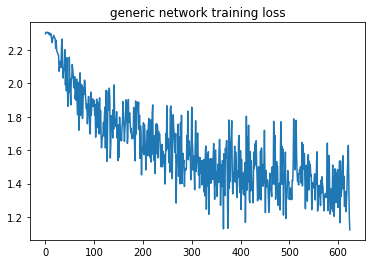

Accuracy: in validation 0.5181999802589417
The Current Loss by validation data: 1.3018714785575867
trigger times did not increase: 0
Iteration: 1 | Loss: 1.3383440971374512 | index 0 
Iteration: 1 | Loss: 1.3946688175201416 | index 100 
Iteration: 1 | Loss: 1.2092915773391724 | index 200 
Iteration: 1 | Loss: 1.1721619367599487 | index 300 
Iteration: 1 | Loss: 1.3210026025772095 | index 400 
Iteration: 1 | Loss: 1.2092514038085938 | index 500 
Iteration: 1 | Loss: 0.9963788986206055 | index 600 
Accuracy: in train 0.4740249812602997


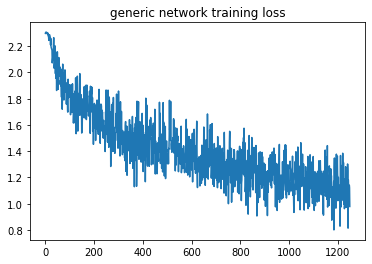

Accuracy: in validation 0.6144999861717224
The Current Loss by validation data: 1.0830227797198448
trigger times did not increase: 0
Iteration: 2 | Loss: 1.1324009895324707 | index 0 
Iteration: 2 | Loss: 0.8325818181037903 | index 100 
Iteration: 2 | Loss: 0.9297333359718323 | index 200 
Iteration: 2 | Loss: 1.4479904174804688 | index 300 
Iteration: 2 | Loss: 1.0738606452941895 | index 400 
Iteration: 2 | Loss: 0.7512103319168091 | index 500 
Iteration: 2 | Loss: 0.9977017641067505 | index 600 
Accuracy: in train 0.5275583267211914


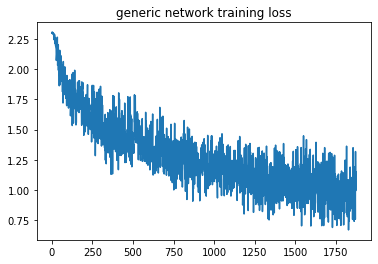

Accuracy: in validation 0.6115999817848206
The Current Loss by validation data: 1.1233896096800542
Trigger Times: 1
Iteration: 3 | Loss: 0.9468232989311218 | index 0 
Iteration: 3 | Loss: 0.9406561851501465 | index 100 
Iteration: 3 | Loss: 1.1496539115905762 | index 200 
Iteration: 3 | Loss: 0.6742362976074219 | index 300 
Iteration: 3 | Loss: 1.0143260955810547 | index 400 
Iteration: 3 | Loss: 0.9830768704414368 | index 500 
Iteration: 3 | Loss: 1.0755019187927246 | index 600 
Accuracy: in train 0.565693736076355


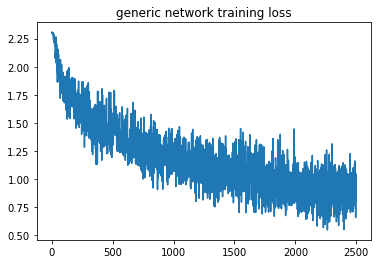

Accuracy: in validation 0.6990000009536743
The Current Loss by validation data: 0.8560058759276274
trigger times did not increase: 1
Iteration: 4 | Loss: 0.7773692011833191 | index 0 
Iteration: 4 | Loss: 0.8453375101089478 | index 100 
Iteration: 4 | Loss: 0.7086828351020813 | index 200 
Iteration: 4 | Loss: 0.7314672470092773 | index 300 
Iteration: 4 | Loss: 0.6847662329673767 | index 400 
Iteration: 4 | Loss: 1.0456664562225342 | index 500 
Iteration: 4 | Loss: 0.9905183911323547 | index 600 
Accuracy: in train 0.5949599742889404


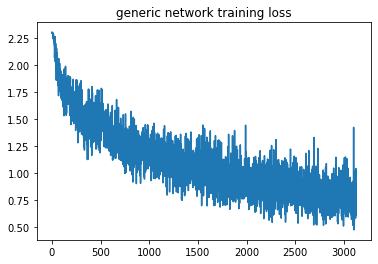

Accuracy: in validation 0.7282999753952026
The Current Loss by validation data: 0.7565751343396059
trigger times did not increase: 0
Iteration: 5 | Loss: 0.8462589383125305 | index 0 
Iteration: 5 | Loss: 0.808077871799469 | index 100 
Iteration: 5 | Loss: 0.7432076334953308 | index 200 
Iteration: 5 | Loss: 0.6403365135192871 | index 300 
Iteration: 5 | Loss: 0.6765037775039673 | index 400 
Iteration: 5 | Loss: 0.9844308495521545 | index 500 
Iteration: 5 | Loss: 0.8067259192466736 | index 600 
Accuracy: in train 0.6189583539962769


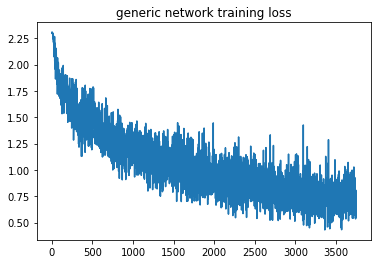

Accuracy: in validation 0.7583000063896179
The Current Loss by validation data: 0.6854085124981631
trigger times did not increase: 0
Iteration: 6 | Loss: 0.6096631288528442 | index 0 
Iteration: 6 | Loss: 0.8310578465461731 | index 100 
Iteration: 6 | Loss: 0.9138136506080627 | index 200 
Iteration: 6 | Loss: 0.5642202496528625 | index 300 
Iteration: 6 | Loss: 0.7480139136314392 | index 400 
Iteration: 6 | Loss: 0.6475687623023987 | index 500 
Iteration: 6 | Loss: 0.6279879212379456 | index 600 
Accuracy: in train 0.6390643119812012


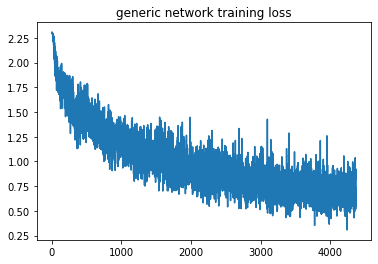

Accuracy: in validation 0.7680000066757202
The Current Loss by validation data: 0.6632709778418207
trigger times did not increase: 0
Iteration: 7 | Loss: 0.5363167524337769 | index 0 
Iteration: 7 | Loss: 0.6157059073448181 | index 100 
Iteration: 7 | Loss: 0.6408039927482605 | index 200 
Iteration: 7 | Loss: 0.7124965786933899 | index 300 
Iteration: 7 | Loss: 0.49254918098449707 | index 400 
Iteration: 7 | Loss: 0.837424099445343 | index 500 
Iteration: 7 | Loss: 0.6546081900596619 | index 600 
Accuracy: in train 0.6559562087059021


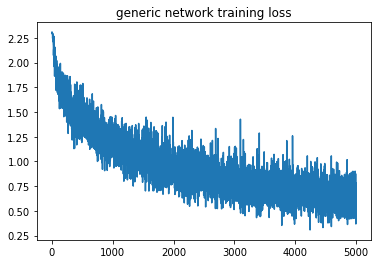

Accuracy: in validation 0.7742999792098999
The Current Loss by validation data: 0.6457723671463644
trigger times did not increase: 0
Iteration: 8 | Loss: 0.6534560918807983 | index 0 
Iteration: 8 | Loss: 0.6297453045845032 | index 100 
Iteration: 8 | Loss: 0.37303873896598816 | index 200 
Iteration: 8 | Loss: 0.506718099117279 | index 300 
Iteration: 8 | Loss: 0.7228302955627441 | index 400 
Iteration: 8 | Loss: 0.6064770221710205 | index 500 
Iteration: 8 | Loss: 0.7106854319572449 | index 600 
Accuracy: in train 0.670977771282196


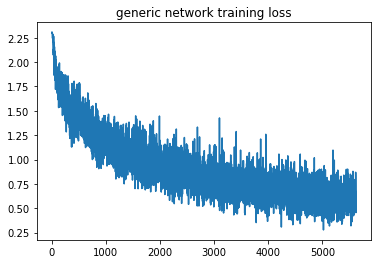

Accuracy: in validation 0.7888000011444092
The Current Loss by validation data: 0.6102489029905599
trigger times did not increase: 0
Iteration: 9 | Loss: 0.5256085395812988 | index 0 
Iteration: 9 | Loss: 0.6328999400138855 | index 100 
Iteration: 9 | Loss: 0.3949603736400604 | index 200 
Iteration: 9 | Loss: 0.5160109400749207 | index 300 
Iteration: 9 | Loss: 0.4619908928871155 | index 400 
Iteration: 9 | Loss: 0.45010659098625183 | index 500 
Iteration: 9 | Loss: 0.5100200772285461 | index 600 
Accuracy: in train 0.6842949986457825


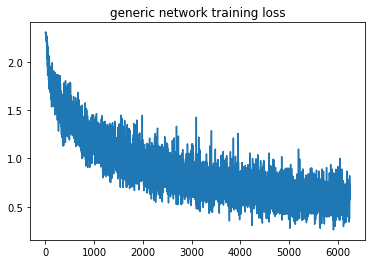

Accuracy: in validation 0.7946999669075012
The Current Loss by validation data: 0.5948642906109998
trigger times did not increase: 0
Iteration: 10 | Loss: 0.7961044907569885 | index 0 
Iteration: 10 | Loss: 0.5273301005363464 | index 100 
Iteration: 10 | Loss: 0.3415311574935913 | index 200 
Iteration: 10 | Loss: 0.6402576565742493 | index 300 
Iteration: 10 | Loss: 0.4460141062736511 | index 400 
Iteration: 10 | Loss: 0.446956068277359 | index 500 
Iteration: 10 | Loss: 0.6545939445495605 | index 600 
Accuracy: in train 0.69623863697052


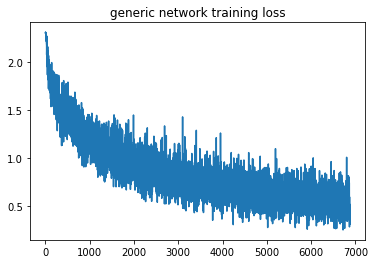

Accuracy: in validation 0.8114999532699585
The Current Loss by validation data: 0.5498766815586454
trigger times did not increase: 0
Iteration: 11 | Loss: 0.42301592230796814 | index 0 
Iteration: 11 | Loss: 0.38517940044403076 | index 100 
Iteration: 11 | Loss: 0.4084886610507965 | index 200 
Iteration: 11 | Loss: 0.6460680365562439 | index 300 
Iteration: 11 | Loss: 0.46850672364234924 | index 400 
Iteration: 11 | Loss: 0.5377907752990723 | index 500 
Iteration: 11 | Loss: 0.4876239001750946 | index 600 
Accuracy: in train 0.7067333459854126


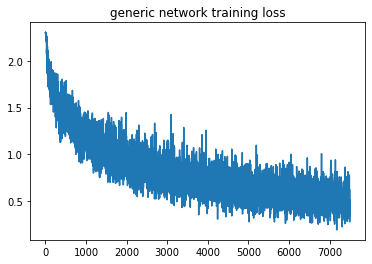

Accuracy: in validation 0.8050999641418457
The Current Loss by validation data: 0.5744018176938318
Trigger Times: 1
Iteration: 12 | Loss: 0.4140590727329254 | index 0 
Iteration: 12 | Loss: 0.5592128038406372 | index 100 
Iteration: 12 | Loss: 0.5522990226745605 | index 200 
Iteration: 12 | Loss: 0.4588342607021332 | index 300 
Iteration: 12 | Loss: 0.37062937021255493 | index 400 
Iteration: 12 | Loss: 0.549284040927887 | index 500 
Iteration: 12 | Loss: 0.6309852004051208 | index 600 
Accuracy: in train 0.7163134813308716


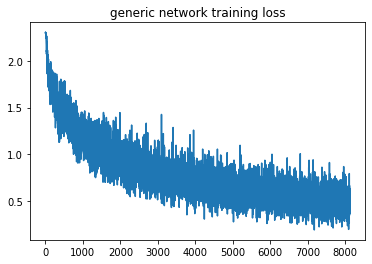

Accuracy: in validation 0.8235999941825867
The Current Loss by validation data: 0.5093500942561278
trigger times did not increase: 1
Iteration: 13 | Loss: 0.4454899728298187 | index 0 
Iteration: 13 | Loss: 0.5515726208686829 | index 100 
Iteration: 13 | Loss: 0.4185626208782196 | index 200 
Iteration: 13 | Loss: 0.764694333076477 | index 300 
Iteration: 13 | Loss: 0.45731911063194275 | index 400 
Iteration: 13 | Loss: 0.6286099553108215 | index 500 
Iteration: 13 | Loss: 0.3352026343345642 | index 600 
Accuracy: in train 0.7252785563468933


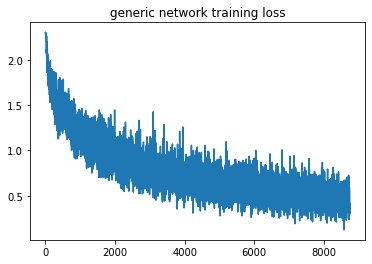

Accuracy: in validation 0.8294999599456787
The Current Loss by validation data: 0.5046522072546041
trigger times did not increase: 0
Iteration: 14 | Loss: 0.5482555627822876 | index 0 
Iteration: 14 | Loss: 0.40196213126182556 | index 100 
Iteration: 14 | Loss: 0.4196055233478546 | index 200 
Iteration: 14 | Loss: 0.6032091975212097 | index 300 
Iteration: 14 | Loss: 0.43678906559944153 | index 400 
Iteration: 14 | Loss: 0.41674208641052246 | index 500 
Iteration: 14 | Loss: 0.32922080159187317 | index 600 
Accuracy: in train 0.7334616780281067


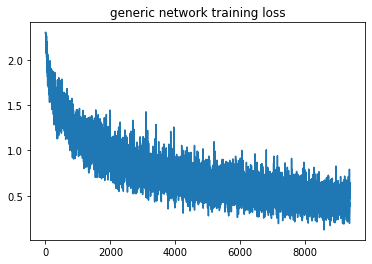

Accuracy: in validation 0.830299973487854
The Current Loss by validation data: 0.5050709828449662
Trigger Times: 1
Iteration: 15 | Loss: 0.4242939352989197 | index 0 
Iteration: 15 | Loss: 0.31458619236946106 | index 100 
Iteration: 15 | Loss: 0.46652576327323914 | index 200 
Iteration: 15 | Loss: 0.2770227789878845 | index 300 
Iteration: 15 | Loss: 0.43663740158081055 | index 400 
Iteration: 15 | Loss: 0.44540783762931824 | index 500 
Iteration: 15 | Loss: 0.6068678498268127 | index 600 
Accuracy: in train 0.7410640716552734


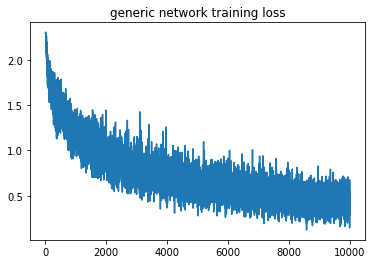

Accuracy: in validation 0.8281999826431274
The Current Loss by validation data: 0.4965687746265132
trigger times did not increase: 1
Iteration: 16 | Loss: 0.2780279219150543 | index 0 
Iteration: 16 | Loss: 0.46988731622695923 | index 100 
Iteration: 16 | Loss: 0.5616312623023987 | index 200 
Iteration: 16 | Loss: 0.465731680393219 | index 300 
Iteration: 16 | Loss: 0.3234822154045105 | index 400 
Iteration: 16 | Loss: 0.23455843329429626 | index 500 
Iteration: 16 | Loss: 0.4073728024959564 | index 600 
Accuracy: in train 0.7481323480606079


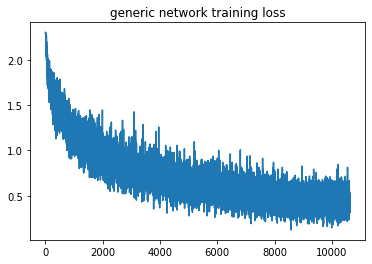

Accuracy: in validation 0.8427000045776367
The Current Loss by validation data: 0.4619323922570344
trigger times did not increase: 0
Iteration: 17 | Loss: 0.34999051690101624 | index 0 
Iteration: 17 | Loss: 0.44127923250198364 | index 100 
Iteration: 17 | Loss: 0.3287891149520874 | index 200 
Iteration: 17 | Loss: 0.34845665097236633 | index 300 
Iteration: 17 | Loss: 0.24169054627418518 | index 400 
Iteration: 17 | Loss: 0.438926637172699 | index 500 
Iteration: 17 | Loss: 0.45992350578308105 | index 600 
Accuracy: in train 0.754604160785675


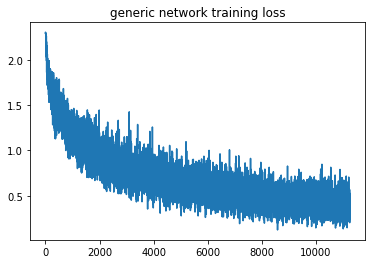

Accuracy: in validation 0.8303999900817871
The Current Loss by validation data: 0.5095281084631659
Trigger Times: 1
Iteration: 18 | Loss: 0.3990305960178375 | index 0 
Iteration: 18 | Loss: 0.3404196500778198 | index 100 
Iteration: 18 | Loss: 0.5630698800086975 | index 200 
Iteration: 18 | Loss: 0.36681923270225525 | index 300 
Iteration: 18 | Loss: 0.2931046485900879 | index 400 
Iteration: 18 | Loss: 0.47053971886634827 | index 500 
Iteration: 18 | Loss: 0.3886709213256836 | index 600 
Accuracy: in train 0.7607802748680115


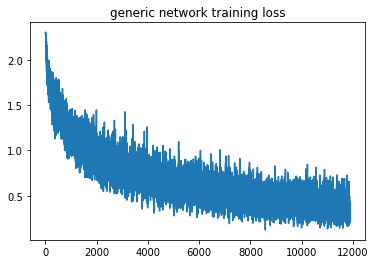

Accuracy: in validation 0.8348999619483948
The Current Loss by validation data: 0.4936471468513938
trigger times did not increase: 1
Iteration: 19 | Loss: 0.3506550192832947 | index 0 
Iteration: 19 | Loss: 0.17754866182804108 | index 100 
Iteration: 19 | Loss: 0.25605207681655884 | index 200 
Iteration: 19 | Loss: 0.47512462735176086 | index 300 
Iteration: 19 | Loss: 0.33224058151245117 | index 400 
Iteration: 19 | Loss: 0.3590381443500519 | index 500 
Iteration: 19 | Loss: 0.5207151770591736 | index 600 
Accuracy: in train 0.7666012048721313


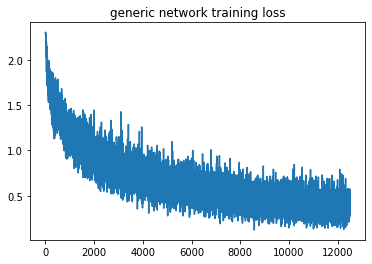

Accuracy: in validation 0.8491999506950378
The Current Loss by validation data: 0.44964612289598793
trigger times did not increase: 0
Iteration: 20 | Loss: 0.25922027230262756 | index 0 
Iteration: 20 | Loss: 0.29836806654930115 | index 100 
Iteration: 20 | Loss: 0.47713685035705566 | index 200 
Iteration: 20 | Loss: 0.35817840695381165 | index 300 
Iteration: 20 | Loss: 0.267061322927475 | index 400 
Iteration: 20 | Loss: 0.3031686544418335 | index 500 
Iteration: 20 | Loss: 0.349557489156723 | index 600 
Accuracy: in train 0.7721107006072998


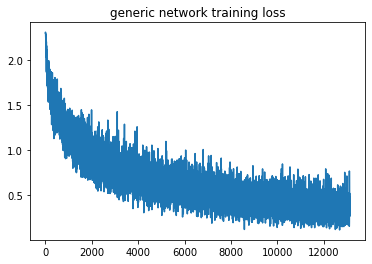

Accuracy: in validation 0.851099967956543
The Current Loss by validation data: 0.44736162966983334
trigger times did not increase: 0
Iteration: 21 | Loss: 0.28624001145362854 | index 0 
Iteration: 21 | Loss: 0.18512244522571564 | index 100 
Iteration: 21 | Loss: 0.2620222568511963 | index 200 
Iteration: 21 | Loss: 0.2974233031272888 | index 300 
Iteration: 21 | Loss: 0.328128844499588 | index 400 
Iteration: 21 | Loss: 0.3497353792190552 | index 500 
Iteration: 21 | Loss: 0.4223690629005432 | index 600 
Accuracy: in train 0.7772238254547119


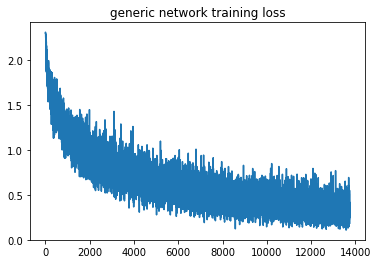

Accuracy: in validation 0.8491999506950378
The Current Loss by validation data: 0.45209177939375494
Trigger Times: 1
Iteration: 22 | Loss: 0.3285958766937256 | index 0 
Iteration: 22 | Loss: 0.3217608630657196 | index 100 
Iteration: 22 | Loss: 0.33577463030815125 | index 200 
Iteration: 22 | Loss: 0.22884191572666168 | index 300 
Iteration: 22 | Loss: 0.38264936208724976 | index 400 
Iteration: 22 | Loss: 0.21730436384677887 | index 500 
Iteration: 22 | Loss: 0.25616544485092163 | index 600 
Accuracy: in train 0.7821239233016968


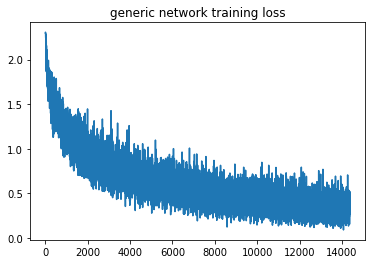

Accuracy: in validation 0.8561999797821045
The Current Loss by validation data: 0.4236584806897838
trigger times did not increase: 1
Iteration: 23 | Loss: 0.17248307168483734 | index 0 
Iteration: 23 | Loss: 0.2944827973842621 | index 100 
Iteration: 23 | Loss: 0.14453670382499695 | index 200 
Iteration: 23 | Loss: 0.5525696873664856 | index 300 
Iteration: 23 | Loss: 0.30039966106414795 | index 400 
Iteration: 23 | Loss: 0.23334066569805145 | index 500 
Iteration: 23 | Loss: 0.37265026569366455 | index 600 
Accuracy: in train 0.786844789981842


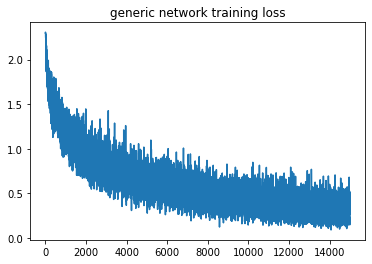

Accuracy: in validation 0.84579998254776
The Current Loss by validation data: 0.46088295558076
Trigger Times: 1
Iteration: 24 | Loss: 0.30170926451683044 | index 0 
Iteration: 24 | Loss: 0.18554168939590454 | index 100 
Iteration: 24 | Loss: 0.33008715510368347 | index 200 
Iteration: 24 | Loss: 0.3594400882720947 | index 300 
Iteration: 24 | Loss: 0.11196577548980713 | index 400 
Iteration: 24 | Loss: 0.2294236123561859 | index 500 
Iteration: 24 | Loss: 0.21410596370697021 | index 600 
Accuracy: in train 0.7912349700927734


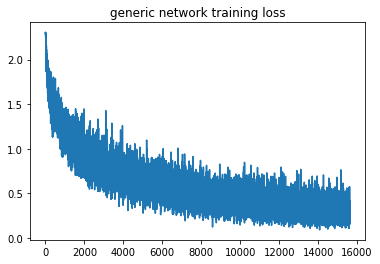

Accuracy: in validation 0.8585999608039856
The Current Loss by validation data: 0.43641249930403037
trigger times did not increase: 1
Iteration: 25 | Loss: 0.32173416018486023 | index 0 
Iteration: 25 | Loss: 0.19656813144683838 | index 100 
Iteration: 25 | Loss: 0.36027631163597107 | index 200 
Iteration: 25 | Loss: 0.35864517092704773 | index 300 
Iteration: 25 | Loss: 0.20692455768585205 | index 400 
Iteration: 25 | Loss: 0.25728288292884827 | index 500 
Iteration: 25 | Loss: 0.41917404532432556 | index 600 
Accuracy: in train 0.7954432964324951


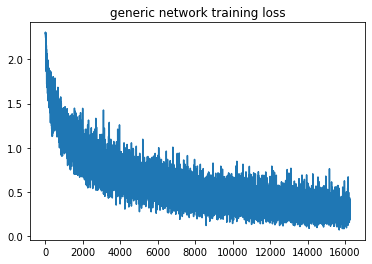

Accuracy: in validation 0.8575999736785889
The Current Loss by validation data: 0.4334554657055314
trigger times did not increase: 0
Iteration: 26 | Loss: 0.2831742465496063 | index 0 
Iteration: 26 | Loss: 0.31434062123298645 | index 100 
Iteration: 26 | Loss: 0.25152838230133057 | index 200 
Iteration: 26 | Loss: 0.3647734522819519 | index 300 
Iteration: 26 | Loss: 0.2968294322490692 | index 400 
Iteration: 26 | Loss: 0.3156217634677887 | index 500 
Iteration: 26 | Loss: 0.2801123559474945 | index 600 
Accuracy: in train 0.7995036840438843


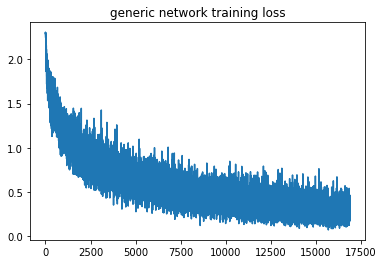

Accuracy: in validation 0.8515999913215637
The Current Loss by validation data: 0.4384154061413115
Trigger Times: 1
Iteration: 27 | Loss: 0.13117021322250366 | index 0 
Iteration: 27 | Loss: 0.1622476428747177 | index 100 
Iteration: 27 | Loss: 0.23388539254665375 | index 200 
Iteration: 27 | Loss: 0.37207385897636414 | index 300 
Iteration: 27 | Loss: 0.25018367171287537 | index 400 
Iteration: 27 | Loss: 0.24140094220638275 | index 500 
Iteration: 27 | Loss: 0.399586021900177 | index 600 
Accuracy: in train 0.8033562302589417


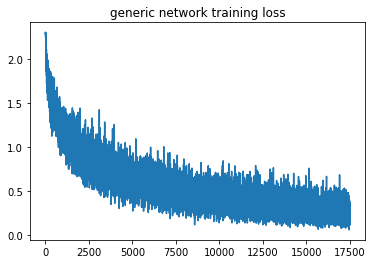

Accuracy: in validation 0.8549999594688416
The Current Loss by validation data: 0.44722453072951857
Trigger Times: 2
Iteration: 28 | Loss: 0.3117406368255615 | index 0 
Iteration: 28 | Loss: 0.30055153369903564 | index 100 
Iteration: 28 | Loss: 0.28776517510414124 | index 200 
Iteration: 28 | Loss: 0.3213513195514679 | index 300 
Iteration: 28 | Loss: 0.1771479845046997 | index 400 
Iteration: 28 | Loss: 0.24182209372520447 | index 500 
Iteration: 28 | Loss: 0.21404576301574707 | index 600 
Accuracy: in train 0.807054340839386


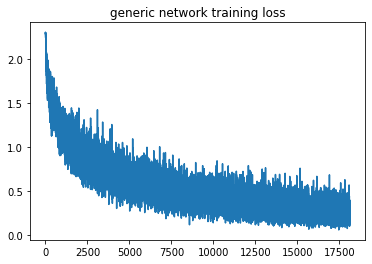

Accuracy: in validation 0.8650999665260315
The Current Loss by validation data: 0.408108498735033
trigger times did not increase: 2
Iteration: 29 | Loss: 0.21119923889636993 | index 0 
Iteration: 29 | Loss: 0.2312319129705429 | index 100 
Iteration: 29 | Loss: 0.1307711899280548 | index 200 
Iteration: 29 | Loss: 0.16070972383022308 | index 300 
Iteration: 29 | Loss: 0.2768876850605011 | index 400 
Iteration: 29 | Loss: 0.2849372625350952 | index 500 
Iteration: 29 | Loss: 0.33668720722198486 | index 600 
Accuracy: in train 0.8105833530426025


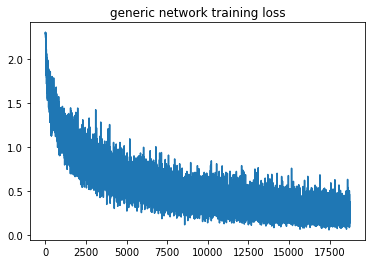

Accuracy: in validation 0.8592999577522278
The Current Loss by validation data: 0.42656620511203813
Trigger Times: 1
Iteration: 30 | Loss: 0.1930823177099228 | index 0 
Iteration: 30 | Loss: 0.16127857565879822 | index 100 
Iteration: 30 | Loss: 0.2907070517539978 | index 200 
Iteration: 30 | Loss: 0.18874207139015198 | index 300 
Iteration: 30 | Loss: 0.22868964076042175 | index 400 
Iteration: 30 | Loss: 0.19302746653556824 | index 500 
Iteration: 30 | Loss: 0.30084410309791565 | index 600 
Accuracy: in train 0.81401127576828


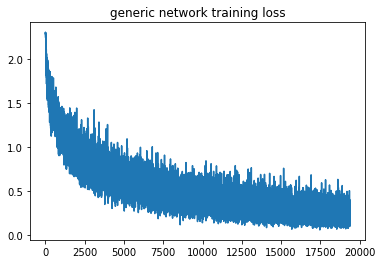

Accuracy: in validation 0.8671999573707581
The Current Loss by validation data: 0.4060098291107803
trigger times did not increase: 1
Iteration: 31 | Loss: 0.24951571226119995 | index 0 
Iteration: 31 | Loss: 0.20860667526721954 | index 100 
Iteration: 31 | Loss: 0.3188004195690155 | index 200 
Iteration: 31 | Loss: 0.28212669491767883 | index 300 
Iteration: 31 | Loss: 0.21104715764522552 | index 400 
Iteration: 31 | Loss: 0.33992618322372437 | index 500 
Iteration: 31 | Loss: 0.25675129890441895 | index 600 
Accuracy: in train 0.8173007369041443


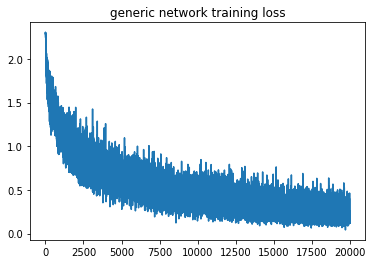

Accuracy: in validation 0.8673999905586243
The Current Loss by validation data: 0.41024008962758785
Trigger Times: 1
Iteration: 32 | Loss: 0.2879640758037567 | index 0 
Iteration: 32 | Loss: 0.17568160593509674 | index 100 
Iteration: 32 | Loss: 0.32703697681427 | index 200 
Iteration: 32 | Loss: 0.16592955589294434 | index 300 
Iteration: 32 | Loss: 0.409017950296402 | index 400 
Iteration: 32 | Loss: 0.3216990530490875 | index 500 
Iteration: 32 | Loss: 0.27203625440597534 | index 600 
Accuracy: in train 0.8205167055130005


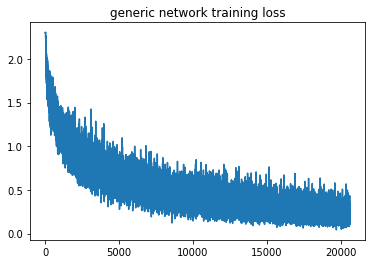

Accuracy: in validation 0.8637999892234802
The Current Loss by validation data: 0.4171980670682944
Trigger Times: 2
Iteration: 33 | Loss: 0.4199531674385071 | index 0 
Iteration: 33 | Loss: 0.12301648408174515 | index 100 
Iteration: 33 | Loss: 0.28918227553367615 | index 200 
Iteration: 33 | Loss: 0.3529393672943115 | index 300 
Iteration: 33 | Loss: 0.20913127064704895 | index 400 
Iteration: 33 | Loss: 0.29511916637420654 | index 500 
Iteration: 33 | Loss: 0.22289663553237915 | index 600 
Accuracy: in train 0.8235529661178589


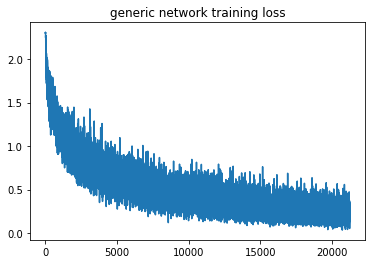

Accuracy: in validation 0.8669999837875366
The Current Loss by validation data: 0.4114046976634651
trigger times did not increase: 2
Iteration: 34 | Loss: 0.23814710974693298 | index 0 
Iteration: 34 | Loss: 0.2220747321844101 | index 100 
Iteration: 34 | Loss: 0.2193818837404251 | index 200 
Iteration: 34 | Loss: 0.2297096997499466 | index 300 
Iteration: 34 | Loss: 0.1178232952952385 | index 400 
Iteration: 34 | Loss: 0.339698851108551 | index 500 
Iteration: 34 | Loss: 0.1549554467201233 | index 600 
Accuracy: in train 0.8264907002449036


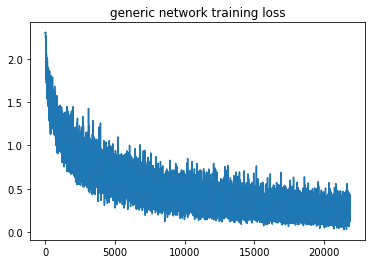

Accuracy: in validation 0.8700999617576599
The Current Loss by validation data: 0.4104057122852392
trigger times did not increase: 0
Iteration: 35 | Loss: 0.23438210785388947 | index 0 
Iteration: 35 | Loss: 0.25517165660858154 | index 100 
Iteration: 35 | Loss: 0.18586085736751556 | index 200 
Iteration: 35 | Loss: 0.17090685665607452 | index 300 
Iteration: 35 | Loss: 0.10159273445606232 | index 400 
Iteration: 35 | Loss: 0.18052610754966736 | index 500 
Iteration: 35 | Loss: 0.26994842290878296 | index 600 
Accuracy: in train 0.8293138742446899


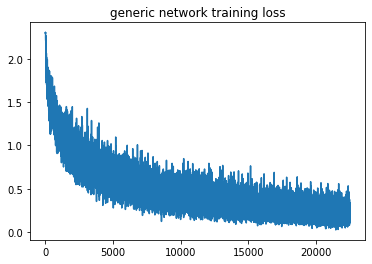

Accuracy: in validation 0.8708999752998352
The Current Loss by validation data: 0.4020083712734235
trigger times did not increase: 0
Iteration: 36 | Loss: 0.1732790470123291 | index 0 
Iteration: 36 | Loss: 0.1618679016828537 | index 100 
Iteration: 36 | Loss: 0.18748795986175537 | index 200 
Iteration: 36 | Loss: 0.21734251081943512 | index 300 
Iteration: 36 | Loss: 0.2775605618953705 | index 400 
Iteration: 36 | Loss: 0.2578820288181305 | index 500 
Iteration: 36 | Loss: 0.2638690769672394 | index 600 
Accuracy: in train 0.8319999575614929


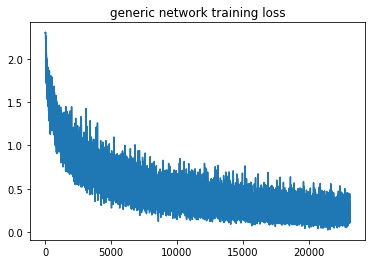

Accuracy: in validation 0.8657999634742737
The Current Loss by validation data: 0.42909511387537996
Trigger Times: 1
Iteration: 37 | Loss: 0.3842833638191223 | index 0 
Iteration: 37 | Loss: 0.14707307517528534 | index 100 
Iteration: 37 | Loss: 0.08583124727010727 | index 200 
Iteration: 37 | Loss: 0.13938505947589874 | index 300 
Iteration: 37 | Loss: 0.21854008734226227 | index 400 
Iteration: 37 | Loss: 0.25224652886390686 | index 500 
Iteration: 37 | Loss: 0.2132885903120041 | index 600 
Accuracy: in train 0.8346381783485413


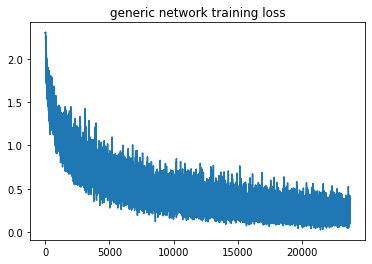

Accuracy: in validation 0.8643999695777893
The Current Loss by validation data: 0.4373503214424583
Trigger Times: 2
Iteration: 38 | Loss: 0.18073415756225586 | index 0 
Iteration: 38 | Loss: 0.12088655680418015 | index 100 
Iteration: 38 | Loss: 0.14998622238636017 | index 200 
Iteration: 38 | Loss: 0.1322973519563675 | index 300 
Iteration: 38 | Loss: 0.1380549967288971 | index 400 
Iteration: 38 | Loss: 0.2248447835445404 | index 500 
Iteration: 38 | Loss: 0.12114473432302475 | index 600 
Accuracy: in train 0.8372288346290588


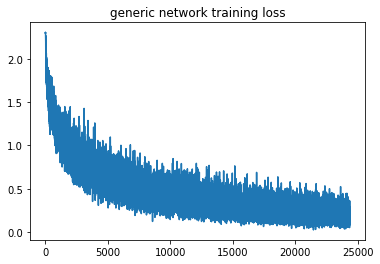

Accuracy: in validation 0.8741999864578247
The Current Loss by validation data: 0.41194538881254805
trigger times did not increase: 2
Iteration: 39 | Loss: 0.22014613449573517 | index 0 
Iteration: 39 | Loss: 0.21193718910217285 | index 100 
Iteration: 39 | Loss: 0.12741734087467194 | index 200 
Iteration: 39 | Loss: 0.24234139919281006 | index 300 
Iteration: 39 | Loss: 0.1780213564634323 | index 400 
Iteration: 39 | Loss: 0.21384938061237335 | index 500 
Iteration: 39 | Loss: 0.30553096532821655 | index 600 
Accuracy: in train 0.8397518396377563


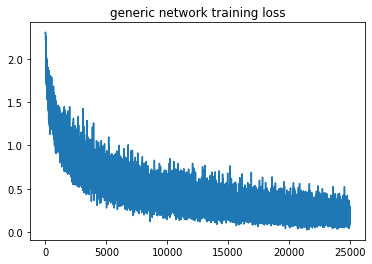

Accuracy: in validation 0.8689000010490417
The Current Loss by validation data: 0.4170255615927611
Trigger Times: 1
Iteration: 40 | Loss: 0.19149149954319 | index 0 
Iteration: 40 | Loss: 0.169646754860878 | index 100 
Iteration: 40 | Loss: 0.22860737144947052 | index 200 
Iteration: 40 | Loss: 0.1544022560119629 | index 300 
Iteration: 40 | Loss: 0.11617211252450943 | index 400 
Iteration: 40 | Loss: 0.23432816565036774 | index 500 
Iteration: 40 | Loss: 0.3473440706729889 | index 600 
Accuracy: in train 0.8421207666397095


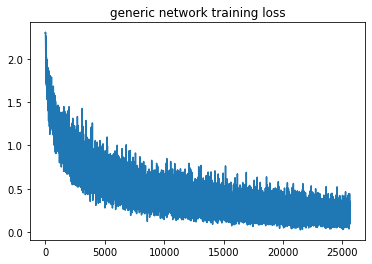

Accuracy: in validation 0.8752999901771545
The Current Loss by validation data: 0.4022512719224972
trigger times did not increase: 1
Iteration: 41 | Loss: 0.3015907108783722 | index 0 
Iteration: 41 | Loss: 0.07134523242712021 | index 100 
Iteration: 41 | Loss: 0.13855646550655365 | index 200 
Iteration: 41 | Loss: 0.2449675053358078 | index 300 
Iteration: 41 | Loss: 0.14741559326648712 | index 400 
Iteration: 41 | Loss: 0.1433429718017578 | index 500 
Iteration: 41 | Loss: 0.16576574742794037 | index 600 
Accuracy: in train 0.84446781873703


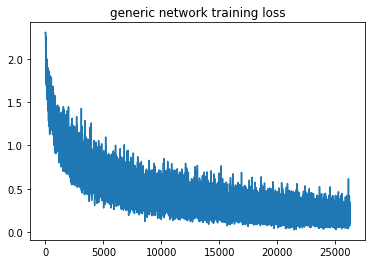

Accuracy: in validation 0.8682999610900879
The Current Loss by validation data: 0.42504280938464367
Trigger Times: 1
Iteration: 42 | Loss: 0.09117665141820908 | index 0 
Iteration: 42 | Loss: 0.11842981725931168 | index 100 
Iteration: 42 | Loss: 0.28945037722587585 | index 200 
Iteration: 42 | Loss: 0.11223462224006653 | index 300 
Iteration: 42 | Loss: 0.3096153736114502 | index 400 
Iteration: 42 | Loss: 0.2525654435157776 | index 500 
Iteration: 42 | Loss: 0.13428142666816711 | index 600 
Accuracy: in train 0.8467005491256714


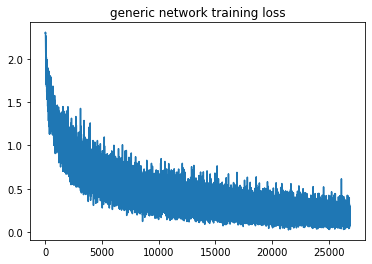

Accuracy: in validation 0.8764999508857727
The Current Loss by validation data: 0.40450338122381524
trigger times did not increase: 1
Iteration: 43 | Loss: 0.10980362445116043 | index 0 
Iteration: 43 | Loss: 0.29968157410621643 | index 100 
Iteration: 43 | Loss: 0.2131263017654419 | index 200 
Iteration: 43 | Loss: 0.21350520849227905 | index 300 
Iteration: 43 | Loss: 0.2413478046655655 | index 400 
Iteration: 43 | Loss: 0.05470210686326027 | index 500 
Iteration: 43 | Loss: 0.41242384910583496 | index 600 
Accuracy: in train 0.848872721195221


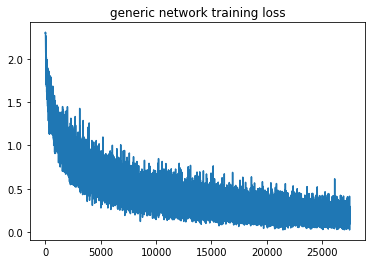

Accuracy: in validation 0.8766999840736389
The Current Loss by validation data: 0.40138679614682105
trigger times did not increase: 0
Iteration: 44 | Loss: 0.06796370446681976 | index 0 
Iteration: 44 | Loss: 0.15086109936237335 | index 100 
Iteration: 44 | Loss: 0.12655004858970642 | index 200 
Iteration: 44 | Loss: 0.16032332181930542 | index 300 
Iteration: 44 | Loss: 0.2080318033695221 | index 400 
Iteration: 44 | Loss: 0.17000485956668854 | index 500 
Iteration: 44 | Loss: 0.234634667634964 | index 600 
Accuracy: in train 0.8509899973869324


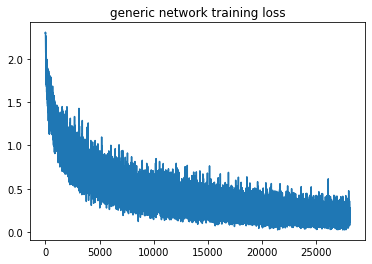

Accuracy: in validation 0.8707000017166138
The Current Loss by validation data: 0.41307647151362364
Trigger Times: 1
Iteration: 45 | Loss: 0.15486198663711548 | index 0 
Iteration: 45 | Loss: 0.055396635085344315 | index 100 
Iteration: 45 | Loss: 0.13710589706897736 | index 200 
Iteration: 45 | Loss: 0.1738772690296173 | index 300 
Iteration: 45 | Loss: 0.0884740799665451 | index 400 
Iteration: 45 | Loss: 0.06620801985263824 | index 500 
Iteration: 45 | Loss: 0.162942573428154 | index 600 
Accuracy: in train 0.8530668616294861


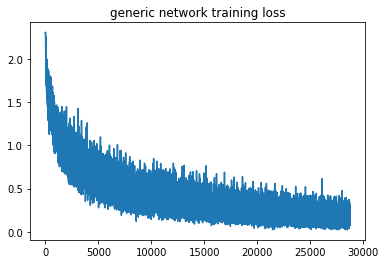

Accuracy: in validation 0.8751999735832214
The Current Loss by validation data: 0.4006337000021509
trigger times did not increase: 1
Iteration: 46 | Loss: 0.19558365643024445 | index 0 
Iteration: 46 | Loss: 0.12664814293384552 | index 100 
Iteration: 46 | Loss: 0.13597090542316437 | index 200 
Iteration: 46 | Loss: 0.1117333471775055 | index 300 
Iteration: 46 | Loss: 0.07638583332300186 | index 400 
Iteration: 46 | Loss: 0.09520988911390305 | index 500 
Iteration: 46 | Loss: 0.07132942229509354 | index 600 
Accuracy: in train 0.8550691604614258


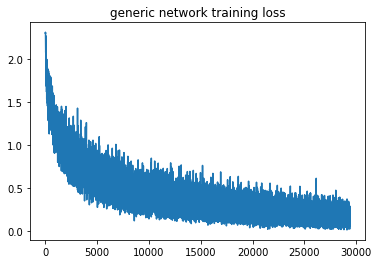

Accuracy: in validation 0.8734999895095825
The Current Loss by validation data: 0.4354585093107952
Trigger Times: 1
Iteration: 47 | Loss: 0.16857287287712097 | index 0 
Iteration: 47 | Loss: 0.1100950837135315 | index 100 
Iteration: 47 | Loss: 0.07650414109230042 | index 200 
Iteration: 47 | Loss: 0.10190246254205704 | index 300 
Iteration: 47 | Loss: 0.12809185683727264 | index 400 
Iteration: 47 | Loss: 0.17776688933372498 | index 500 
Iteration: 47 | Loss: 0.058218859136104584 | index 600 
Accuracy: in train 0.8569968938827515


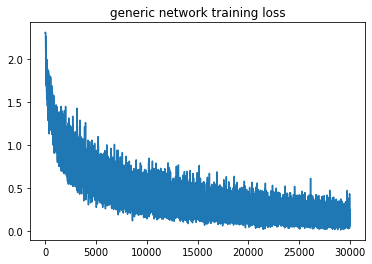

Accuracy: in validation 0.8769999742507935
The Current Loss by validation data: 0.40991805664672976
trigger times did not increase: 1
Iteration: 48 | Loss: 0.052146151661872864 | index 0 
Iteration: 48 | Loss: 0.054764412343502045 | index 100 
Iteration: 48 | Loss: 0.1814727783203125 | index 200 
Iteration: 48 | Loss: 0.08429192751646042 | index 300 
Iteration: 48 | Loss: 0.19941620528697968 | index 400 
Iteration: 48 | Loss: 0.2524350881576538 | index 500 
Iteration: 48 | Loss: 0.033193644136190414 | index 600 
Accuracy: in train 0.8589147925376892


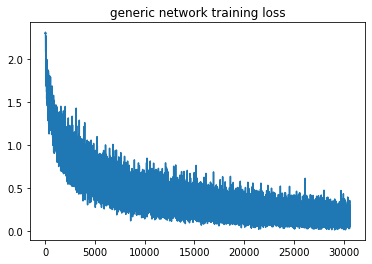

Accuracy: in validation 0.8780999779701233
The Current Loss by validation data: 0.41226535845714013
Trigger Times: 1
Iteration: 49 | Loss: 0.13538064062595367 | index 0 
Iteration: 49 | Loss: 0.07459529489278793 | index 100 
Iteration: 49 | Loss: 0.1409134566783905 | index 200 
Iteration: 49 | Loss: 0.11843202263116837 | index 300 
Iteration: 49 | Loss: 0.13061809539794922 | index 400 
Iteration: 49 | Loss: 0.1001572236418724 | index 500 
Iteration: 49 | Loss: 0.11951825767755508 | index 600 
Accuracy: in train 0.8607460260391235


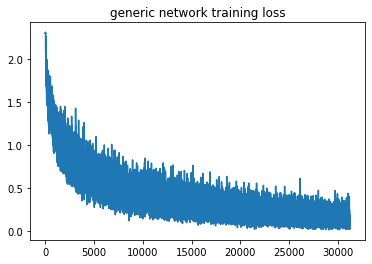

Accuracy: in validation 0.8705999851226807
The Current Loss by validation data: 0.46420576893220283
Trigger Times: 2
Iteration: 50 | Loss: 0.08385607600212097 | index 0 
Iteration: 50 | Loss: 0.2197609543800354 | index 100 
Iteration: 50 | Loss: 0.06696712970733643 | index 200 
Iteration: 50 | Loss: 0.1846676766872406 | index 300 
Iteration: 50 | Loss: 0.24310635030269623 | index 400 
Iteration: 50 | Loss: 0.09320998936891556 | index 500 
Iteration: 50 | Loss: 0.2069849669933319 | index 600 
Accuracy: in train 0.8625603318214417


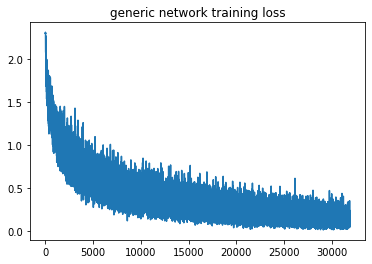

Accuracy: in validation 0.8787999749183655
The Current Loss by validation data: 0.4051618531915792
trigger times did not increase: 2
Iteration: 51 | Loss: 0.1548094004392624 | index 0 
Iteration: 51 | Loss: 0.07177475094795227 | index 100 
Iteration: 51 | Loss: 0.11192424595355988 | index 200 
Iteration: 51 | Loss: 0.03193221986293793 | index 300 
Iteration: 51 | Loss: 0.1782502382993698 | index 400 
Iteration: 51 | Loss: 0.15196271240711212 | index 500 
Iteration: 51 | Loss: 0.2340620905160904 | index 600 
Accuracy: in train 0.8643346428871155


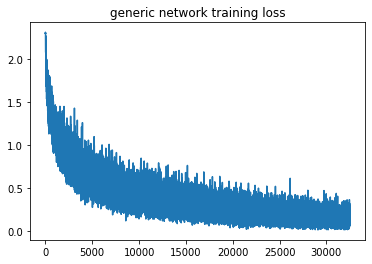

Accuracy: in validation 0.8754000067710876
The Current Loss by validation data: 0.4218463056311486
Trigger Times: 1
Iteration: 52 | Loss: 0.16151723265647888 | index 0 
Iteration: 52 | Loss: 0.11381828039884567 | index 100 
Iteration: 52 | Loss: 0.17547568678855896 | index 200 
Iteration: 52 | Loss: 0.17891880869865417 | index 300 
Iteration: 52 | Loss: 0.07170015573501587 | index 400 
Iteration: 52 | Loss: 0.12614908814430237 | index 500 
Iteration: 52 | Loss: 0.052336715161800385 | index 600 
Accuracy: in train 0.8660566210746765


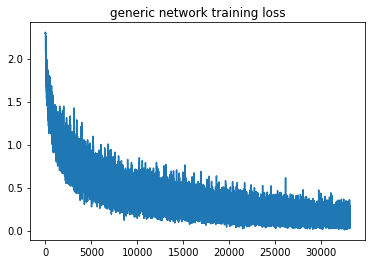

Accuracy: in validation 0.8708999752998352
The Current Loss by validation data: 0.4573334936693216
Trigger Times: 2
Iteration: 53 | Loss: 0.19458873569965363 | index 0 
Iteration: 53 | Loss: 0.09426341205835342 | index 100 
Iteration: 53 | Loss: 0.07399186491966248 | index 200 
Iteration: 53 | Loss: 0.22296133637428284 | index 300 
Iteration: 53 | Loss: 0.20663750171661377 | index 400 
Iteration: 53 | Loss: 0.2882639467716217 | index 500 
Iteration: 53 | Loss: 0.04370890557765961 | index 600 
Accuracy: in train 0.867707371711731


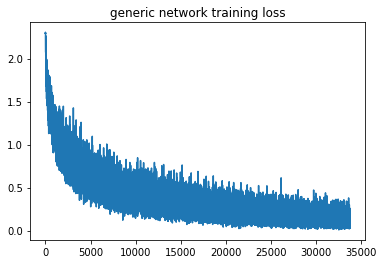

Accuracy: in validation 0.8823999762535095
The Current Loss by validation data: 0.42134142225715004
trigger times did not increase: 2
Iteration: 54 | Loss: 0.21618333458900452 | index 0 
Iteration: 54 | Loss: 0.13999545574188232 | index 100 
Iteration: 54 | Loss: 0.08297112584114075 | index 200 
Iteration: 54 | Loss: 0.05759742483496666 | index 300 
Iteration: 54 | Loss: 0.17206458747386932 | index 400 
Iteration: 54 | Loss: 0.0712248906493187 | index 500 
Iteration: 54 | Loss: 0.11154019832611084 | index 600 
Accuracy: in train 0.8693413138389587


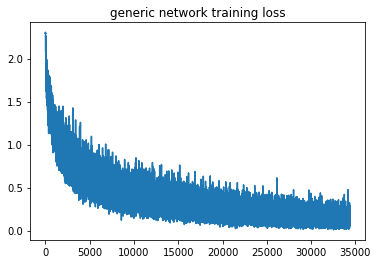

Accuracy: in validation 0.8799999952316284
The Current Loss by validation data: 0.4294276040071135
Trigger Times: 1
Iteration: 55 | Loss: 0.168385311961174 | index 0 
Iteration: 55 | Loss: 0.14332547783851624 | index 100 
Iteration: 55 | Loss: 0.1515558809041977 | index 200 
Iteration: 55 | Loss: 0.20883917808532715 | index 300 
Iteration: 55 | Loss: 0.21471351385116577 | index 400 
Iteration: 55 | Loss: 0.13986220955848694 | index 500 
Iteration: 55 | Loss: 0.22469240427017212 | index 600 
Accuracy: in train 0.8709227442741394


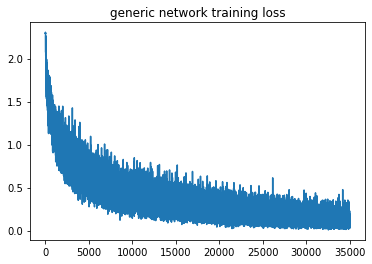

Accuracy: in validation 0.8786999583244324
The Current Loss by validation data: 0.4343766853403134
Trigger Times: 2
Iteration: 56 | Loss: 0.15292087197303772 | index 0 
Iteration: 56 | Loss: 0.045482635498046875 | index 100 
Iteration: 56 | Loss: 0.1863042265176773 | index 200 
Iteration: 56 | Loss: 0.07857867330312729 | index 300 
Iteration: 56 | Loss: 0.21586164832115173 | index 400 
Iteration: 56 | Loss: 0.13833269476890564 | index 500 
Iteration: 56 | Loss: 0.05159345641732216 | index 600 
Accuracy: in train 0.8725004196166992


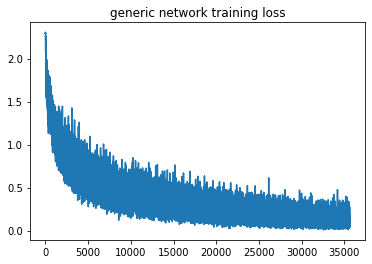

Accuracy: in validation 0.8792999982833862
The Current Loss by validation data: 0.4295907814981072
trigger times did not increase: 2
Iteration: 57 | Loss: 0.18219931423664093 | index 0 
Iteration: 57 | Loss: 0.12526537477970123 | index 100 
Iteration: 57 | Loss: 0.13898351788520813 | index 200 
Iteration: 57 | Loss: 0.2987987697124481 | index 300 
Iteration: 57 | Loss: 0.0928397923707962 | index 400 
Iteration: 57 | Loss: 0.11787142604589462 | index 500 
Iteration: 57 | Loss: 0.07805462926626205 | index 600 
Accuracy: in train 0.8739858269691467


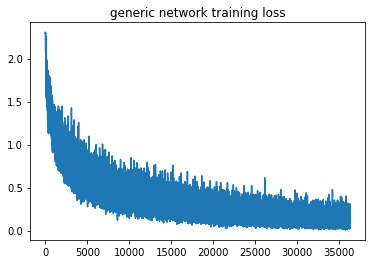

Accuracy: in validation 0.8854999542236328
The Current Loss by validation data: 0.41527524011529937
trigger times did not increase: 0
Iteration: 58 | Loss: 0.050160620361566544 | index 0 
Iteration: 58 | Loss: 0.21690189838409424 | index 100 
Iteration: 58 | Loss: 0.1150246113538742 | index 200 
Iteration: 58 | Loss: 0.06488314270973206 | index 300 
Iteration: 58 | Loss: 0.09396237879991531 | index 400 
Iteration: 58 | Loss: 0.1430985927581787 | index 500 
Iteration: 58 | Loss: 0.07940158247947693 | index 600 
Accuracy: in train 0.8754542469978333


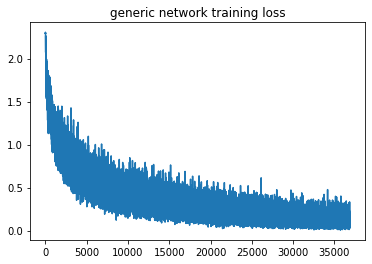

Accuracy: in validation 0.8792999982833862
The Current Loss by validation data: 0.43381052089344924
Trigger Times: 1
Iteration: 59 | Loss: 0.07515445351600647 | index 0 
Iteration: 59 | Loss: 0.06396621465682983 | index 100 
Iteration: 59 | Loss: 0.124643474817276 | index 200 
Iteration: 59 | Loss: 0.12070879340171814 | index 300 
Iteration: 59 | Loss: 0.12639103829860687 | index 400 
Iteration: 59 | Loss: 0.13206560909748077 | index 500 
Iteration: 59 | Loss: 0.21794718503952026 | index 600 
Accuracy: in train 0.8768925070762634


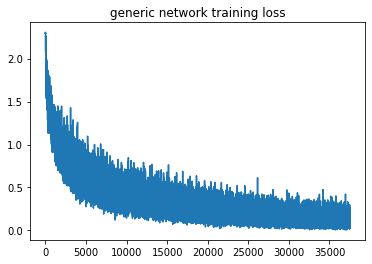

Accuracy: in validation 0.8836999535560608
The Current Loss by validation data: 0.42228084228410845
trigger times did not increase: 1
Iteration: 60 | Loss: 0.18991734087467194 | index 0 
Iteration: 60 | Loss: 0.10114705562591553 | index 100 
Iteration: 60 | Loss: 0.08205455541610718 | index 200 
Iteration: 60 | Loss: 0.10685493797063828 | index 300 
Iteration: 60 | Loss: 0.024468600749969482 | index 400 
Iteration: 60 | Loss: 0.12095526605844498 | index 500 
Iteration: 60 | Loss: 0.03217880800366402 | index 600 
Accuracy: in train 0.8783069849014282


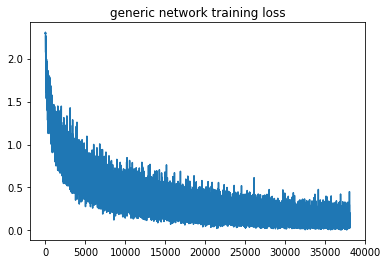

Accuracy: in validation 0.8793999552726746
The Current Loss by validation data: 0.43204744179157695
Trigger Times: 1
Iteration: 61 | Loss: 0.06842450052499771 | index 0 
Iteration: 61 | Loss: 0.05806075036525726 | index 100 
Iteration: 61 | Loss: 0.07151197642087936 | index 200 
Iteration: 61 | Loss: 0.06049550697207451 | index 300 
Iteration: 61 | Loss: 0.027072807773947716 | index 400 
Iteration: 61 | Loss: 0.07191476225852966 | index 500 
Iteration: 61 | Loss: 0.07176639139652252 | index 600 
Accuracy: in train 0.8796697854995728


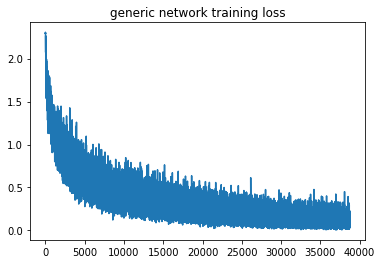

Accuracy: in validation 0.8794999718666077
The Current Loss by validation data: 0.42541191551336055
trigger times did not increase: 1
Iteration: 62 | Loss: 0.06382980942726135 | index 0 
Iteration: 62 | Loss: 0.10427418351173401 | index 100 
Iteration: 62 | Loss: 0.06198782101273537 | index 200 
Iteration: 62 | Loss: 0.18843114376068115 | index 300 
Iteration: 62 | Loss: 0.06899227201938629 | index 400 
Iteration: 62 | Loss: 0.13168184459209442 | index 500 
Iteration: 62 | Loss: 0.16235145926475525 | index 600 
Accuracy: in train 0.8809813261032104


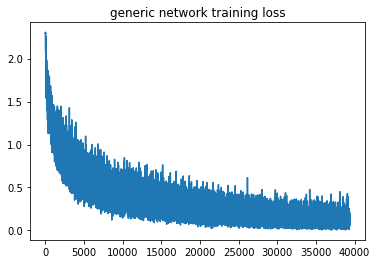

Accuracy: in validation 0.8761000037193298
The Current Loss by validation data: 0.47150577248851205
Trigger Times: 1
Iteration: 63 | Loss: 0.05678575113415718 | index 0 
Iteration: 63 | Loss: 0.11688224226236343 | index 100 
Iteration: 63 | Loss: 0.14846014976501465 | index 200 
Iteration: 63 | Loss: 0.10712514817714691 | index 300 
Iteration: 63 | Loss: 0.03351452946662903 | index 400 
Iteration: 63 | Loss: 0.11102383583784103 | index 500 
Iteration: 63 | Loss: 0.1317189633846283 | index 600 
Accuracy: in train 0.8822753429412842


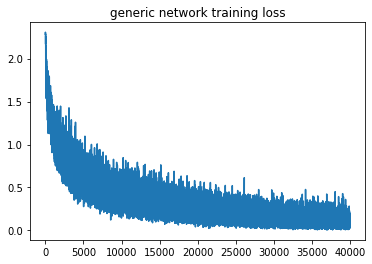

Accuracy: in validation 0.8786999583244324
The Current Loss by validation data: 0.436744797903641
trigger times did not increase: 1
Iteration: 64 | Loss: 0.14555057883262634 | index 0 
Iteration: 64 | Loss: 0.0699368491768837 | index 100 
Iteration: 64 | Loss: 0.016681024804711342 | index 200 
Iteration: 64 | Loss: 0.06751428544521332 | index 300 
Iteration: 64 | Loss: 0.14570720493793488 | index 400 
Iteration: 64 | Loss: 0.10324165225028992 | index 500 
Iteration: 64 | Loss: 0.047791775315999985 | index 600 
Accuracy: in train 0.8835358023643494


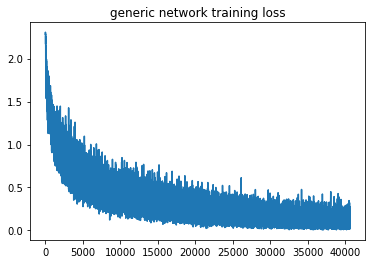

Accuracy: in validation 0.8842999935150146
The Current Loss by validation data: 0.4236998217310875
trigger times did not increase: 0
Iteration: 65 | Loss: 0.07975559681653976 | index 0 
Iteration: 65 | Loss: 0.06463496387004852 | index 100 
Iteration: 65 | Loss: 0.10315757244825363 | index 200 
Iteration: 65 | Loss: 0.015437235124409199 | index 300 
Iteration: 65 | Loss: 0.11072902381420135 | index 400 
Iteration: 65 | Loss: 0.08718783408403397 | index 500 
Iteration: 65 | Loss: 0.11657094955444336 | index 600 
Accuracy: in train 0.8847860097885132


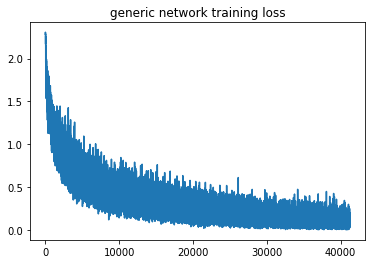

Accuracy: in validation 0.883899986743927
The Current Loss by validation data: 0.43032121691544345
Trigger Times: 1
Iteration: 66 | Loss: 0.13555635511875153 | index 0 
Iteration: 66 | Loss: 0.2971346080303192 | index 100 
Iteration: 66 | Loss: 0.15083152055740356 | index 200 
Iteration: 66 | Loss: 0.2358940839767456 | index 300 
Iteration: 66 | Loss: 0.06674923747777939 | index 400 
Iteration: 66 | Loss: 0.08357303589582443 | index 500 
Iteration: 66 | Loss: 0.09907498955726624 | index 600 
Accuracy: in train 0.8860040903091431


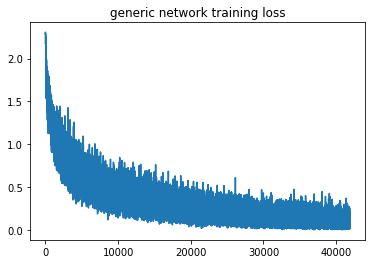

Accuracy: in validation 0.8858000040054321
The Current Loss by validation data: 0.3956689127501409
trigger times did not increase: 1
Iteration: 67 | Loss: 0.1059701144695282 | index 0 
Iteration: 67 | Loss: 0.019922705367207527 | index 100 
Iteration: 67 | Loss: 0.08577599376440048 | index 200 
Iteration: 67 | Loss: 0.051356662064790726 | index 300 
Iteration: 67 | Loss: 0.045350655913352966 | index 400 
Iteration: 67 | Loss: 0.16346557438373566 | index 500 
Iteration: 67 | Loss: 0.22669300436973572 | index 600 
Accuracy: in train 0.8872330784797668


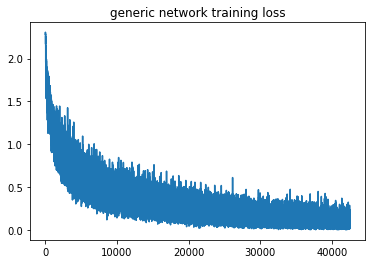

Accuracy: in validation 0.8826999664306641
The Current Loss by validation data: 0.447364571415315
Trigger Times: 1
Iteration: 68 | Loss: 0.05201262608170509 | index 0 
Iteration: 68 | Loss: 0.07419174164533615 | index 100 
Iteration: 68 | Loss: 0.13976319134235382 | index 200 
Iteration: 68 | Loss: 0.08324902504682541 | index 300 
Iteration: 68 | Loss: 0.11734415590763092 | index 400 
Iteration: 68 | Loss: 0.09061799943447113 | index 500 
Iteration: 68 | Loss: 0.07433390617370605 | index 600 
Accuracy: in train 0.8883960247039795


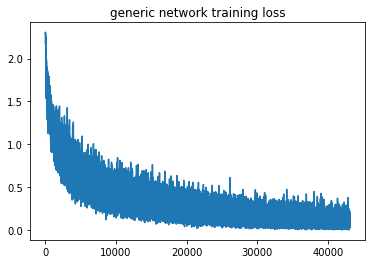

Accuracy: in validation 0.8816999793052673
The Current Loss by validation data: 0.43945691067796605
trigger times did not increase: 1
Iteration: 69 | Loss: 0.16204926371574402 | index 0 
Iteration: 69 | Loss: 0.15776073932647705 | index 100 
Iteration: 69 | Loss: 0.017898719757795334 | index 200 
Iteration: 69 | Loss: 0.07468308508396149 | index 300 
Iteration: 69 | Loss: 0.07362814992666245 | index 400 
Iteration: 69 | Loss: 0.1045224666595459 | index 500 
Iteration: 69 | Loss: 0.11926820129156113 | index 600 
Accuracy: in train 0.8895242810249329


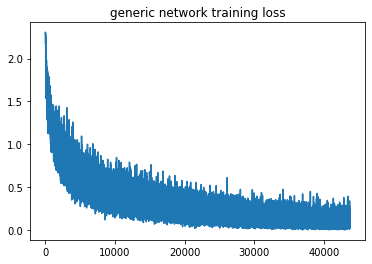

Accuracy: in validation 0.8792999982833862
The Current Loss by validation data: 0.4409683235701482
Trigger Times: 1


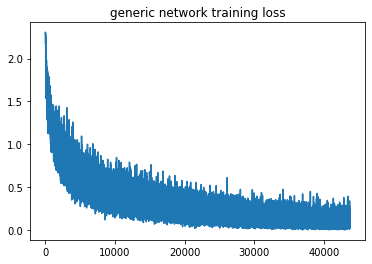

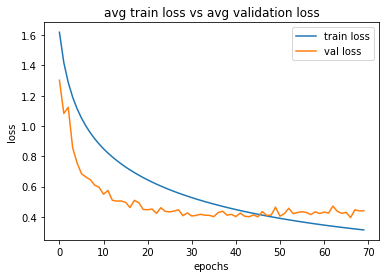

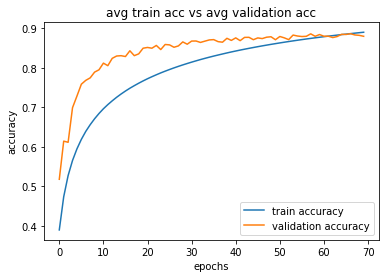

Test accuracy for clean model:  0.8849999904632568


Finished Training model




In [16]:

##################################################
# step 1 - initialize and train model

vanilla_model = CNN_model().to(device)  # with dropout, batch, without FC layers
summary(vanilla_model, input_size=(3, 32, 32))
# print(model)

PATH = './vanilla_model.pth'
vanilla_model = train_data(vanilla_model, max_epochs, 0.0001, loss_fn, train_loader, val_loader, PATH, patience=5)
torch.save(vanilla_model.state_dict(), PATH)

vanilla_model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
vanilla_acc = test_data(vanilla_model, test_loader, "Test accuracy for clean model: ")
print('\n\nFinished Training model\n\n')



below are calls for the different attacks and defenses

Test accuracy for clean model attacked by deepfool: 0.07449999451637268
Accuracy under fgsm attack 0.0993
index is: 4, sum_diff is: 5
index is: 4, sum_diff is: 5
Accuracy: in test of deepfool 0.0
(3, 32, 32)


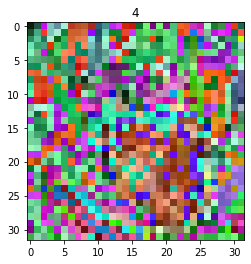

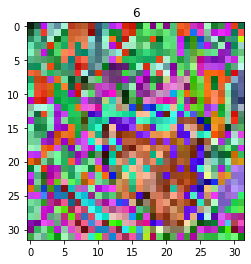

AttributeError: ignored

In [21]:
#################################################
# step 2: adv attack - deep fool, fgsm on clean data

attacked_deepfool = calling_deepfool(vanilla_model, test_for_adv)

deepfool_acc = test_data(vanilla_model, attacked_deepfool, "Test accuracy for clean model attacked by deepfool:")

fgsm_acc, perturbed_images_fgsm = Checker(vanilla_model, test_for_adv, 0.1) # fgsm attack on clean data


testing_deepfool(vanilla_model, test_for_adv) #visualizing deepfool attack results



In [ ]:
#################################################
#step 3: adv training and then retest deepfool

# batched_deepfool_train(model, train_loader)
# tensor_adv_images = torch.load('./final_adv_images.pt', map_location=torch.device(device))
# #print(tensor_adv_images[0].shape)
#print('\n\nFinished creating batched images\n\n')

# model_adv_train = CNN_model().to(device)
# PATH_ADV = './model_train_adv.pth'
# epochs = 100
# model_adv_train = adversarial_train(model_adv_train, epochs, 0.0001, loss_fn,
#                                     train_loader, val_loader, PATH_ADV, tensor_adv_images)
# model_adv_train.load_state_dict(torch.load(PATH_ADV, map_location=torch.device(device)))

# test_data(model_adv_train, test_loader)

# adv_training_deepfool = calling_deepfool(model, test_for_adv)

# adv_train_deepfool_acc = test_data(model_adv_train, adv_training_deepfool)



In [ ]:
#################################################
# step 3: fgsm adversarial training

PATH_ADV_fgsm = './model_train_adv_fgsm.pth'
epochs = 100  # was 100
model_adv_train_fg = CNN_model().to(device)
model_adv_train_fg = adversarial_train(vanilla_model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV_fgsm)
model_adv_train_fg.load_state_dict(torch.load(PATH_ADV_fgsm))
adv_train_fgsm_clean_acc, currupt_fgsm_outputs = Checker(model_adv_train_fg, test_for_adv, 0.1)


In [ ]:
#################################################
#step 4: apply feature squeezing and then test fgsm attack
PATH_SQUEEZED = './model_squeezed.pth'
model_squeezed_train = CNN_model().to(device)
model_squeezed_train = train_data(model_squeezed_train, max_epochs, 0.0001, loss_fn, train_loader, val_loader,
                                   PATH_SQUEEZED, feature_squeezing = True)  # squeezed_images instead train loader

test_feature_squeezing(train_loader)

model_squeezed_train.load_state_dict(torch.load(PATH_SQUEEZED, map_location=torch.device(device)))

#adv attack - fgsm on pre-processed data data
adv_train_fgsm_clean_acc = test_data(model_squeezed_train, test_loader, "Test accuracy of model with pre-process of feature squeezing: ")

#generating perturbed images on original model
acc, perturbed_images = Checker(vanilla_model, test_for_adv, 0.1)

# testing defend against fgsm attack
squeezed_fgsm_corrupt_acc = test_data(model_squeezed_train, perturbed_images, "Test accuracy of attacked model via fgsm after feature squeezing: ")

print("Test accuracy of attacked model via fgsm without defenses: ")
adv_train_fgsm_corrupt_acc, perturbed_feature_squeeze = Checker(vanilla_model, test_for_adv, 0.1)



In [ ]:
#################################################
# step 5: apply feauture squeezing defense and then test deepfool attack

PATH_SQUEEZED = './model_squeezed.pth'
model_squeezed_train = CNN_model().to(device)
model_squeezed_train = train_data(model_squeezed_train, max_epochs, 0.0001, loss_fn, train_loader, val_loader,
                                  PATH_SQUEEZED, feature_squeezing = True)  # squeezed_images instead train loader

model_squeezed_train.load_state_dict(torch.load(PATH_SQUEEZED, map_location=torch.device(device)))

squeezed_deepfool_clean_acc = test_data(model_squeezed_train, test_loader, "Test accuracy of model pre-processed with feature squeezing: ")

# adv attack - deep fool on original model
attacked_deepfool_squeezed_im = calling_deepfool(vanilla_model, test_for_adv)

# testing model accuracy of adversary input from deepfool attack. model tested is after pre-processing of training
squeezed_deepfool_corrupt_acc = test_data(model_squeezed_train, attacked_deepfool_squeezed_im, "Test accuracy of attacked model via deepfool after feature squeezing: ")




In [ ]:

#step 6: Summary 
print("\n\nBottom Line:")
table=[
        {"Defense\Attack": "None", "DeepFool":  round(deepfool_acc*100,2), "FSGM":  round(fgsm_acc*100,2), "None": round(vanilla_acc*100,2)},
        {"Defense\Attack": "Adversarial Training", "DeepFool":  round(adv_train_deepfool_corrupt_acc*100,2), "FSGM": round(adv_train_fgsm_corrupt_acc*100,2), "None - deepfool": round(adv_train_deepfool_clean_acc*100,2), "None - fgsm": round(adv_train_fgsm_clean_acc*100,2)},
        {"Defense\Attack": "Feature Squeezing", "DeepFool":  round(squeezed_deepfool_corrupt_acc*100,2), "FSGM": round(squeezed_fgsm_corrupt_acc*100,2), "None - deepfool": round(squeezed_deepfool_clean_acc*100,2), "None - fgsm": round(squeezed_deepfool_clean_acc*100,2)}
]
print(tabulate(table, headers='keys', tablefmt='fancy_grid'))